In [ ]:
"""
This code has been sourced in part from
https://github.com/sarthak15169/Deep-Music
drawn from the same paper and in turn sourced in part from an online tutorial
https://www.hackerearth.com/blog/machine-learning/jazz-music-using-deep-learning/,
modified for our needs.
"""

import sys
import re
import numpy as np
import pandas as pd
import music21
from music21 import converter, instrument, note, chord, stream
from glob import glob
import IPython
from tqdm import tqdm
import pickle
import tensorflow
import tensorflow.keras

In [ ]:
# Make sure songs are in below folder, imported if run through colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## To upload and unzip files
# import zipfile

# zip_file_path = '/content/bach.zip'
# extraction_directory = '/content/drive/MyDrive/Bach'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extraction_directory)

# print(f"Successfully extracted '{zip_file_path}' to '{extraction_directory}'")


Successfully extracted '/content/bach.zip' to '/content'


In [ ]:
songs = glob('/content/drive/MyDrive/Bach/*.mid')
valid_midi_files = []
songs[0]

'/content/drive/MyDrive/Bach/brand51.mid'

In [ ]:
def get_notes():
    notes = []
    for file in songs:
        try:
            # converting .mid file to stream object
            midi = converter.parse(file)
            notes_to_parse = []
            try:
                # Given a single stream, partition into a part for each unique instrument
                parts = instrument.partitionByInstrument(midi)
            except:
                pass

            if parts: # if parts has instrument parts
                notes_to_parse = parts.parts[1].recurse()
            else:
                notes_to_parse = midi.flat.notes

            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    # if element is a note, extract pitch
                    notes.append(str(element.pitch))
                elif(isinstance(element, chord.Chord)):
                    # if element is a chord, append the normal form of the
                    # chord (a list of integers) to the list of notes.
                    notes.append('.'.join(str(n) for n in element.normalOrder))
        except Exception as e:
            print('Failed at file: ', file, "Reason: ", e)
        else:
            valid_midi_files.append(file)
    with open('/content/notes.mid', 'ab') as filepath:
        pickle.dump(notes, filepath)

    return notes

In [ ]:
from tensorflow.keras.utils import to_categorical

def prepare_sequences(notes, n_vocab):
    sequence_length = 50

    # Extract the unique pitches in the list of notes.
    pitchnames = sorted(set(item for item in notes))

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i: i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format comatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

    # normalize input
    network_input = network_input / float(n_vocab)

    # one hot encode the output vectors
    network_output = to_categorical(network_output)

    return (network_input, network_output)

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten
def create_network(network_in, n_vocab):
    """Create the model architecture"""
    model = Sequential()
    model.add(LSTM(128, input_shape=network_in.shape[1:], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [ ]:
from keras.callbacks import ModelCheckpoint
def train(model, network_input, network_output, epochs):
    """
    Train the neural network
    """
    # Create checkpoint to save the best model weights.
    filepath = 'weights2.best.music3.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True)

    model.fit(network_input, network_output, epochs=epochs, batch_size=50, callbacks=[checkpoint])

In [ ]:
def train_network():
    """
    Get notes
    Generates input and output sequences
    Creates a model
    Trains the model for the given epochs
    """

    epochs = 50

    notes = get_notes()
    print('Notes processed')

    n_vocab = len(set(notes))
    print('Vocab generated')

    network_in, network_out = prepare_sequences(notes, n_vocab)
    print('Input and Output processed')

    model = create_network(network_in, n_vocab)
    print('Model created')

    print('Training in progress')
    train(model, network_in, network_out, epochs)
    print('Training completed')

    return model

In [ ]:
### Train the model
train_network()

Failed at file:  /content/drive/MyDrive/Bach/cnt1.mid Reason:  list index out of range
Failed at file:  /content/drive/MyDrive/Bach/can2.mid Reason:  list index out of range
Failed at file:  /content/drive/MyDrive/Bach/can4.mid Reason:  list index out of range
Failed at file:  /content/drive/MyDrive/Bach/04couran.mid Reason:  list index out of range
Failed at file:  /content/drive/MyDrive/Bach/04allema.mid Reason:  list index out of range
Failed at file:  /content/drive/MyDrive/Bach/04prelud.mid Reason:  list index out of range
Failed at file:  /content/drive/MyDrive/Bach/04gigue.mid Reason:  list index out of range
Failed at file:  /content/drive/MyDrive/Bach/04bourre.mid Reason:  list index out of range
Failed at file:  /content/drive/MyDrive/Bach/01prelud.mid Reason:  list index out of range
Failed at file:  /content/drive/MyDrive/Bach/cnt2.mid Reason:  list index out of range
Failed at file:  /content/drive/MyDrive/Bach/01couran.mid Reason:  list index out of range
Failed at file: 

In [ ]:
def generate():
    """ Generate a piano midi file """
    #load the notes used to train the model
    with open('/content/notes.mid', 'rb') as filepath:
        notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))

    print('Initiating music generation process.......')

    network_input = get_inputSequences(notes, pitchnames, n_vocab)
    model = create_network(network_input, n_vocab)
    print('Loading Model weights.....')
    model.load_weights('weights2.best.music3.hdf5')
    print('Model Loaded')
    prediction_output, _, _ = generate_notes(model, network_input, pitchnames, n_vocab)
    create_midi(prediction_output)

In [ ]:
def get_inputSequences(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 50
    network_input = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])

    n_patterns = len(network_input)
    print ('n_patterns ', n_patterns)
    print ('n_vocab ', n_vocab)

    # reshape the input into a format comatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

    # normalize input
    network_input = network_input / float(n_vocab)

    return (network_input)

In [ ]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # Pick a random integer
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    # pick a random sequence from the input as a starting point for the prediction
    pattern = network_input[start]
    print ('pattern.shape', pattern.shape)
    prediction_inputs = []
    prediction_output = []
    prediction_output_ints = []

    print('Generating notes........')

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)
        prediction_inputs.append(prediction_input)

        prediction = model.predict(prediction_input, verbose=0)

        # Predicted output is the argmax(P(h|D))
        index = np.argmax(prediction)
        # Mapping the predicted interger back to the corresponding note
        result = int_to_note[index]
        # Storing the predicted output
        prediction_output.append(result)
        prediction_output_ints.append(index)

        pattern = np.append(pattern, index)
        # Next input to the model
        pattern = pattern[1:len(pattern)]

    print('Notes Generated...')
    return prediction_output, prediction_output_ints, prediction_inputs

In [ ]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    print('Saving Output file as midi....')

    midi_stream.write('midi', fp='test_output.mid')

In [ ]:
#### Generate a new jazz music
generate()

Initiating music generation process.......
n_patterns  62313
n_vocab  204
Loading Model weights.....
Model Loaded
pattern.shape (50, 1)
Generating notes........
Notes Generated...
Saving Output file as midi....


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns

#def visualize():
#load the notes used to train the model
with open('/content/notes.mid', 'rb') as filepath:
    notes = pickle.load(filepath)

# Get all pitch names
pitchnames = sorted(set(item for item in notes))
# Get all pitch names
n_vocab = len(set(notes))

print('Initiating visualization.......')

network_input = get_inputSequences(notes, pitchnames, n_vocab)*float(n_vocab)
model = create_network(network_input, n_vocab)
print('Loading Model weights.....')
model.load_weights('weights2.best.music3.hdf5')
print('Model Loaded')
prediction_output, prediction_output_ints, prediction_inputs = generate_notes(model, network_input, pitchnames, n_vocab)

Initiating visualization.......
n_patterns  62313
n_vocab  204
Loading Model weights.....
Model Loaded
pattern.shape (50, 1)
Generating notes........
Notes Generated...


In [ ]:
model2 = tensorflow.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
features = []
for i in prediction_inputs:
    features.append(model2(i))

In [ ]:
t = np.reshape(features, (len(features), 204))
t

array([[-14.222193 , -24.250454 , -33.7522   , ...,   2.584222 ,
         -1.028373 , -20.422604 ],
       [ -4.548604 , -12.424072 , -14.685907 , ...,   2.82514  ,
          3.9301314,  -9.112555 ],
       [-15.755516 , -30.58087  , -34.52371  , ...,   1.3527573,
          0.2729   , -22.329819 ],
       ...,
       [-17.988964 , -33.524895 , -32.333492 , ...,   5.212635 ,
         -6.3010497, -20.417603 ],
       [-17.988964 , -33.524895 , -32.333492 , ...,   5.212635 ,
         -6.3010497, -20.417603 ],
       [-17.988964 , -33.524895 , -32.333492 , ...,   5.212635 ,
         -6.3010497, -20.417603 ]], dtype=float32)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.000001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.731224
[t-SNE] KL divergence after 1000 iterations: 0.573173


<ipython-input-73-835e0345e7e2>:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(current_tx, current_ty, c=c, label=classes[idx])


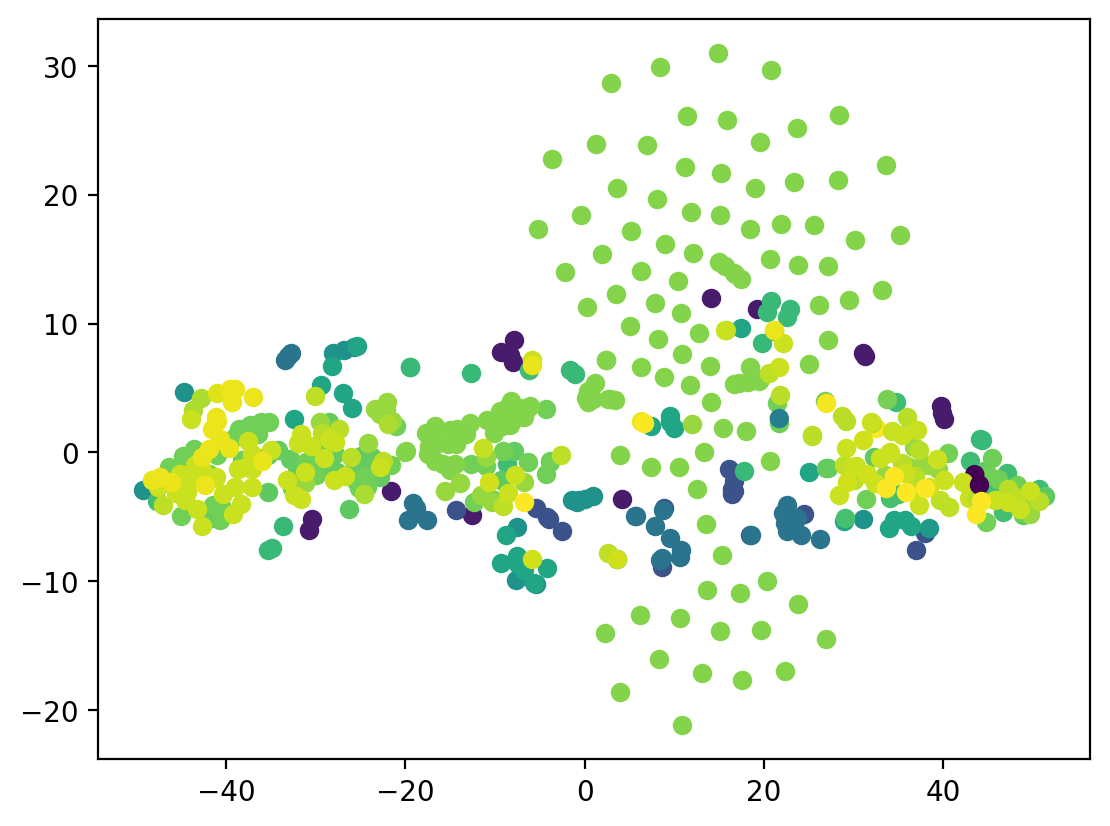

In [ ]:
tsne = TSNE(n_components=2, verbose=1).fit_transform(t)

def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

#tx = scale_to_01_range(tx)
#ty = scale_to_01_range(ty)

colors = mpl.colormaps['viridis'].resampled(len(pitchnames))
classes = pitchnames
#print(classes)
fig = plt.figure()
ax = fig.add_subplot(111)
for idx, c in enumerate(colors.colors):
    indices = [i for i, l in enumerate(prediction_output_ints) if idx == l]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

#ax.legend(loc='best')
plt.show()

In [ ]:
with open('/content/notes.mid', 'rb') as filepath:
    notes = pickle.load(filepath)

df = pd.DataFrame(notes)

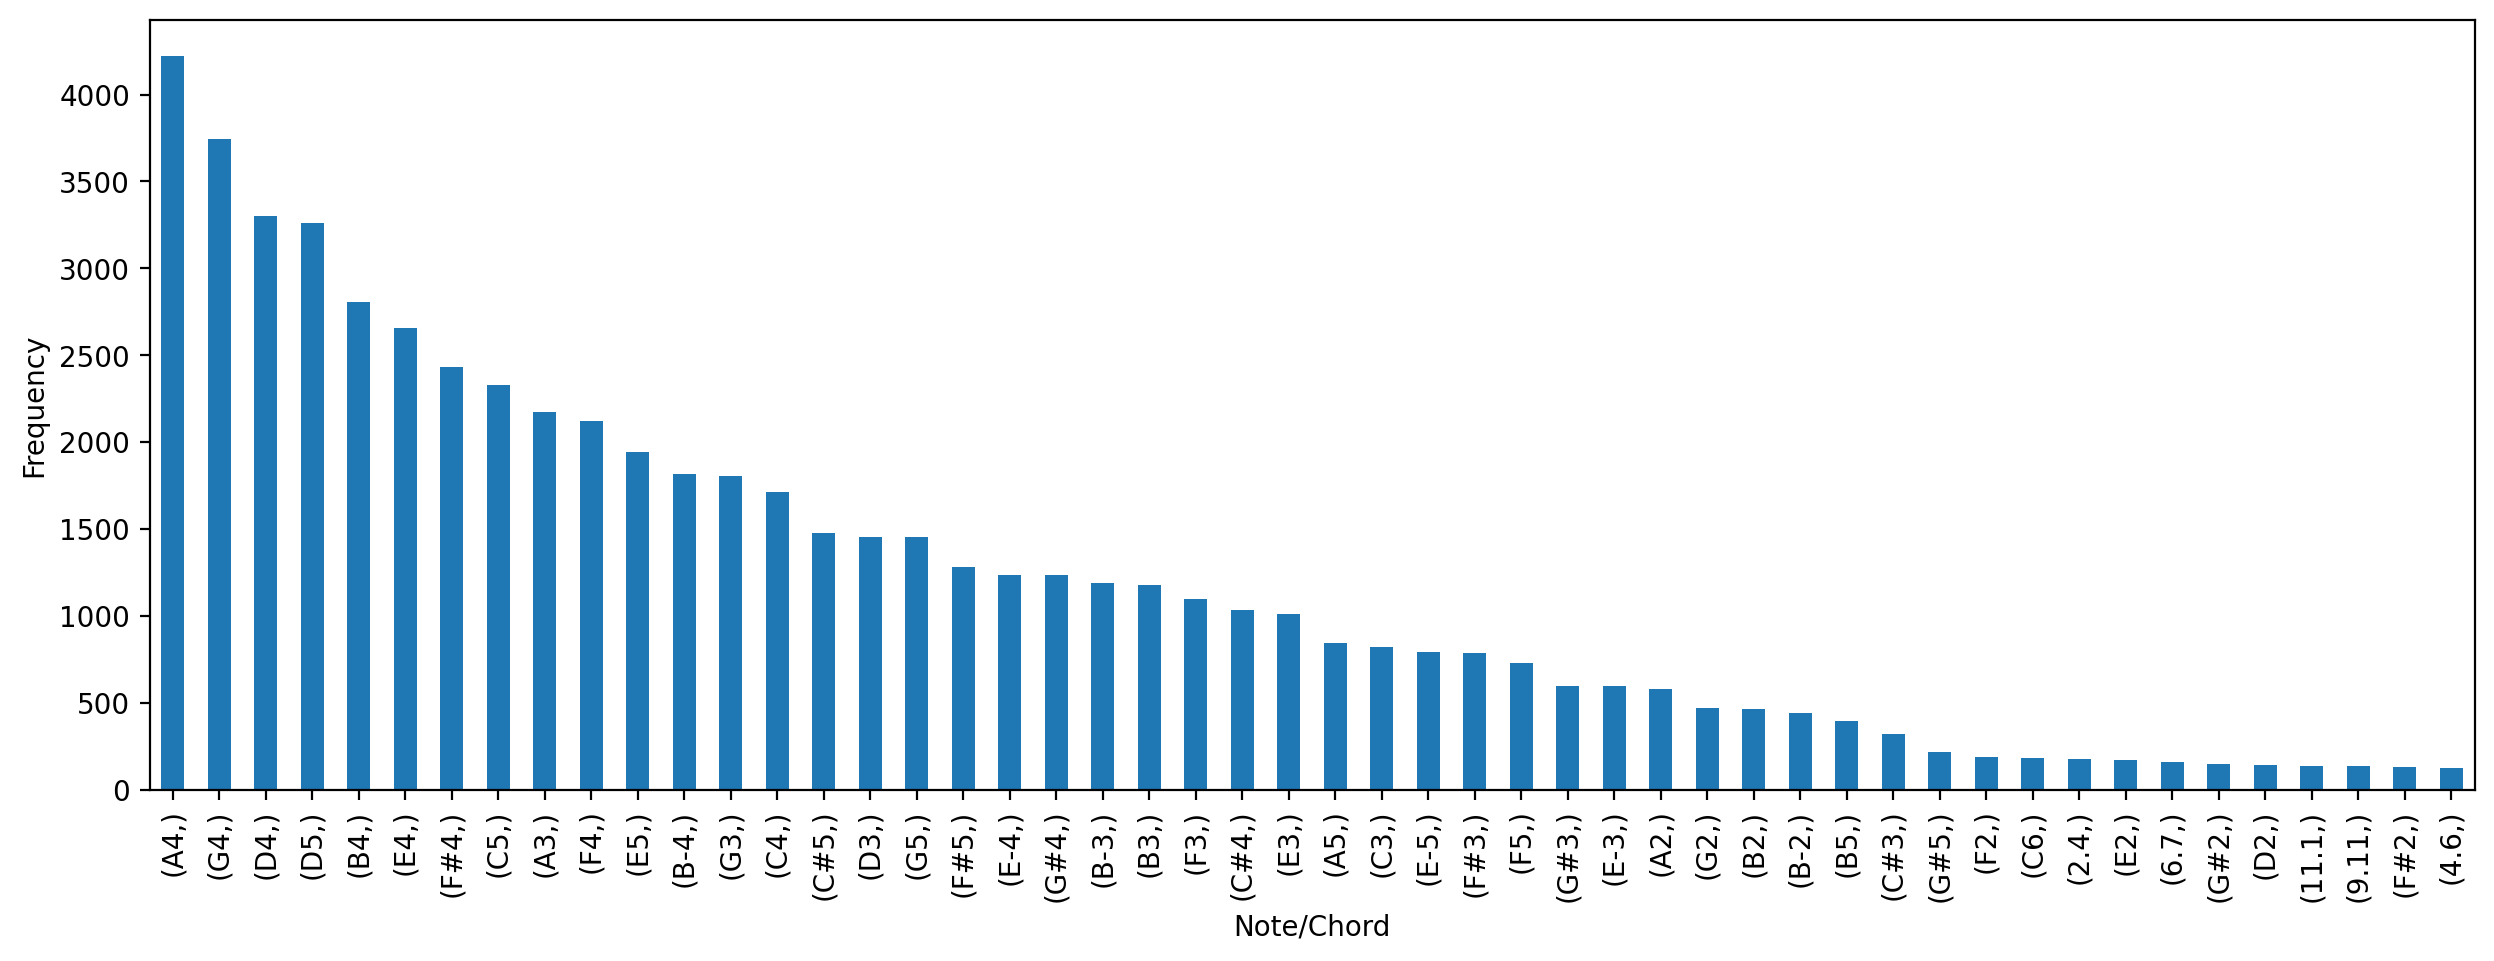

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt
import pandas

fig, ax = plt.subplots(figsize=(15,5))
df.value_counts()[:50].plot(ax=ax, kind='bar')
plt.xlabel('Note/Chord')
plt.ylabel('Frequency')
fig.savefig('data.jpg')

In [ ]:
len(notes)

62363